<a href="https://colab.research.google.com/github/bhogasena/BikeSharingDemad/blob/main/Bike_Sharing_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Sharing Demand Prediction and Interpretation using Linear Regression

## Problem Statement

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

Compnay wants to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market.

The company wants to know:

*   Which variables are significant in predicting the demand for shared bikes.
*   How well those variables describe the bike demands




## Step 1: Reading and Understanding the Data

In [347]:
import numpy as np
import pandas as pd
import sklearn
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import warnings
pd.options.display.max_columns=None


In [348]:
bike_df = pd.read_csv("day.csv")
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [349]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### Data Cleaning


*   instant is unique id and so we can delete.
*   dteday as well can be deleted as we already have month and year in separate columns
*   As we are dealing with total bike shares, we can drop casual and registered columns as well.






In [350]:
bike_df.drop(['instant','dteday','casual','registered'],inplace=True,axis=1)

In [351]:
bike_df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


## Step 2: Visualising the Data

### Quantitative Continuous Variables Analysis using scatter plot

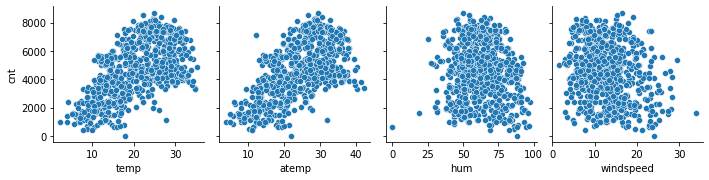

In [352]:
cont_vars = ['temp','atemp','hum','windspeed']
dep_vars=['cnt']
sns.pairplot(bike_df,x_vars=cont_vars,y_vars=dep_vars)
plt.show()

#### Observations

As per above plots, there seems to be linear relationship for temperature and feeling temperature with total rental bikes

In [353]:
desc_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
def create_box_plot(x_var,y_var,row,col,title,bins):
  tr1 = go.Histogram(x=bike_df[x_var],y=bike_df[y_var],histfunc='sum')
  tr1.update(name=title)
  fig.add_trace(tr1,row,col)
  fig.update_xaxes(title={
        'text': title},row=row,col=col)

fig = make_subplots(3,3,shared_yaxes=True)
create_box_plot('season','cnt',1,1,'Season',{'start':1,'end':4,'size':1})
create_box_plot('yr','cnt',1,2,'Year',{'start':0,'end':2,'size':1})
create_box_plot('mnth','cnt',1,3,'Month',{'start':1,'end':12,'size':1})
create_box_plot('holiday','cnt',2,1,'Holiday',{'start':0,'end':1,'size':1})
create_box_plot('weekday','cnt',2,2,'Weekday',{'start':0,'end':6,'size':1})
create_box_plot('workingday','cnt',2,3,'Workingday',{'start':0,'end':1,'size':1})
create_box_plot('weathersit','cnt',3,1,'Weathersit',{'start':1,'end':4,'size':1})

fig.update_layout(width=1200,height=1200,barmode='group', bargap=0.15)
fig.update_yaxes(title={'text':"Total Bikes Rented"},row=1,col=1)
fig.show()

#### Observations

*   Summer and fall seasons have more bikes rented compared to spring and winter
*   Seems bikes rentals increases year by year
*   May to September months have higher bike rentals compared to other months
*   Seems non-holidays have more bike rentals compared to holdiays.
*   There seems to be no significance difference on weekdays.
*   Working days have higher bike rentals.
*   Clear weather have higher bike rentals

## Step 3: Data Preparation

In [354]:
bike_df = pd.get_dummies(bike_df,columns=['season','mnth','weathersit','weekday'],prefix=["Season","Month","weathersit","Weekday"],drop_first=True)


In [355]:
bike_df.rename(columns={"Season_2":"isSummer","Season_3":"isFall","Season_4":"isWinter","Year_1":"Year_2019","weathersit_2":"Mist","weathersit_3":"Light_Snow_Rain"},inplace=True)

In [356]:
bike_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,isSummer,isFall,isWinter,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Mist,Light_Snow_Rain,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Step 4: Splitting the Data into Training and Testing Sets

In [357]:
np.random.seed(1)
bike_train_df, bike_test_df = train_test_split(bike_df,train_size=0.7, test_size=0.3, random_state=100)


### Rescaling the Features 

In [358]:
scalar = MinMaxScaler()
scalar_cols = ['temp','atemp','hum','windspeed','cnt']
scalar.fit(bike_train_df[scalar_cols])
bike_train_df[scalar_cols] = scalar.transform(bike_train_df[scalar_cols])
bike_test_df[scalar_cols] = scalar.transform(bike_test_df[scalar_cols])
bike_train_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,isSummer,isFall,isWinter,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Mist,Light_Snow_Rain,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [359]:
px.imshow(bike_train_df[['temp','atemp','cnt','hum','windspeed']].corr(),text_auto=True)

#### Observations

*   Temperature and feeling temperature are highly correlated. We see VIFs in later sections below
*   As feeling tempeterature ('atemp')  is correlated with bike rentals we start with this variable first to build a model



## Step 5: Building a linear model

In [360]:
y_train = bike_train_df.pop('cnt')
X_train = bike_train_df
y_test = bike_test_df.pop('cnt')
X_test = bike_test_df
X_train_sk = X_train.copy()
y_train_sk = y_train.copy()

## Manual - Model 1

In [361]:
def linear_model(x_vars,df):
  X_train_lm = sm.add_constant(df[x_vars])
  model =  sm.OLS(y_train, X_train_lm).fit()
  print(model.summary())
  return model



#### Let's build a linear regression model with one variable 'atemp' first as this has high correlation with dependent variable 'cnt'

In [362]:
lr_atemp = linear_model(['atemp'],X_train)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     364.7
Date:                Fri, 03 Jun 2022   Prob (F-statistic):           1.10e-61
Time:                        02:01:17   Log-Likelihood:                 176.51
No. Observations:                 510   AIC:                            -349.0
Df Residuals:                     508   BIC:                            -340.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1629      0.020      8.199      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



Lets also build with 'temp' variable alone.  As we know 'temp and 'atemp' are highly correlated we need to drop of of these.

## Manual - Model 2

In [363]:
lr_temp = linear_model(['temp'],X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     359.1
Date:                Fri, 03 Jun 2022   Prob (F-statistic):           5.80e-61
Time:                        02:01:17   Log-Likelihood:                 174.84
No. Observations:                 510   AIC:                            -345.7
Df Residuals:                     508   BIC:                            -337.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1698      0.020      8.628      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



#### Let's build a model together with 'temp' annd 'atemp

## Manual - Model 3

In [364]:
lr2 = linear_model(['temp','atemp'],X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     182.5
Date:                Fri, 03 Jun 2022   Prob (F-statistic):           1.95e-60
Time:                        02:01:17   Log-Likelihood:                 176.81
No. Observations:                 510   AIC:                            -347.6
Df Residuals:                     507   BIC:                            -334.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1634      0.020      8.215      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



#### Observations


*   We can clearly see that when we add feeling temperature('atemp') and 'temp' though R2 increased very slightly  F-Static value decreased significantly. That means overall model is not good fit.
*   We can obviously see the P- value of temp is greater than significane level we need to remove this from our model. Let's also see VIF as we saw in correlation matrix temp and atemp are highly correlated.



In [365]:
def get_vif(df):
  vif = pd.DataFrame()
  vif['features'] = df.columns
  vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  print(vif)

In [366]:
get_vif(bike_train_df)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning:

divide by zero encountered in double_scalars



           features     VIF
24        Weekday_2     inf
2        workingday     inf
23        Weekday_1     inf
27        Weekday_5     inf
26        Weekday_4     inf
25        Weekday_3     inf
1           holiday     inf
3              temp  447.70
4             atemp  383.54
5               hum   20.79
8            isFall   15.42
16          Month_8   11.01
9          isWinter   10.93
15          Month_7    9.62
7          isSummer    8.88
14          Month_6    7.35
17          Month_9    7.34
13          Month_5    7.16
18         Month_10    6.64
19         Month_11    5.99
12          Month_4    5.64
6         windspeed    4.71
20         Month_12    3.78
11          Month_3    3.06
21             Mist    2.21
0                yr    2.09
28        Weekday_6    1.93
10          Month_2    1.71
22  Light_Snow_Rain    1.23


#### Observation


*   'temp' variable VIF is also highest among all variables. and also P > significance level of 0.05. So we can eliminate 'temp' from our model features.



## Manual - Model 4

In [367]:
## Add one more variable 'hum'
lr3 = linear_model(['atemp','hum'],X_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     205.3
Date:                Fri, 03 Jun 2022   Prob (F-statistic):           4.74e-66
Time:                        02:01:18   Log-Likelihood:                 189.81
No. Observations:                 510   AIC:                            -373.6
Df Residuals:                     507   BIC:                            -360.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3217      0.036      8.910      0.0

#### Observations

*   R2 increased from 0.418 to 0.448




## Manual - Model 5

In [368]:
## Add one more variable 'windspeed'
lr4 = linear_model(['atemp','hum','windspeed'],X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     152.1
Date:                Fri, 03 Jun 2022   Prob (F-statistic):           2.90e-70
Time:                        02:01:18   Log-Likelihood:                 202.43
No. Observations:                 510   AIC:                            -396.9
Df Residuals:                     506   BIC:                            -379.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4520      0.044     10.357      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



#### Observations

*   R2 increased from 0.448 to 0.474

Let's include all variables and see ....

## Manual - Model 6

In [369]:
### Adding All variables to Model
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     99.96
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          8.42e-181
Time:                        02:01:18   Log-Likelihood:                 528.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     481   BIC:                            -875.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1756      0.030     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



#### Observations

*  Weekday_4 has highest P value and so delete this feature and rebuild the model.



In [370]:
X_train.drop(['Weekday_4'],axis=1,inplace=True)


## Manual - Model 7

In [371]:
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     99.96
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          8.42e-181
Time:                        02:01:18   Log-Likelihood:                 528.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     481   BIC:                            -875.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1756      0.030     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



### Observations


*   There is no change in R2 even after we drop Weekday4. That means Weekday4 is not significance variable to describe the dependent variable 'cnt'
*   Drop next highest P-value feature 'Weekday_3'



## Manual - Model 8

In [372]:
X_train.drop(['Weekday_3'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     103.9
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          8.49e-182
Time:                        02:01:18   Log-Likelihood:                 527.99
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     482   BIC:                            -881.4
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1754      0.030     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



#### Observations

*   R2- still same and F-Static got increased and that means overall model is good compared to previous model.
*   Drop the highest p-value column 'atemp'





## Manual - Model 9

In [373]:
X_train.drop(['atemp'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     108.0
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          8.61e-183
Time:                        02:01:18   Log-Likelihood:                 527.92
No. Observations:                 510   AIC:                            -1002.
Df Residuals:                     483   BIC:                            -887.5
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1758      0.030     

Lets drop the variables one by one and rebuild model and keep delete until we have features which P-values are less than significance level 0.05

## Manual - Model 10

In [374]:
X_train.drop(['Weekday_5'],axis=1,inplace=True) # drop Weekday_5 as this has highest P-value
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     112.5
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          9.26e-184
Time:                        02:01:18   Log-Likelihood:                 527.77
No. Observations:                 510   AIC:                            -1004.
Df Residuals:                     484   BIC:                            -893.4
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1762      0.030     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



## Manual - Model 11

In [375]:
X_train.drop(['Month_7'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     117.4
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          9.74e-185
Time:                        02:01:18   Log-Likelihood:                 527.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     485   BIC:                            -899.4
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1771      0.030     

## Manual - Model 12

In [376]:
X_train.drop(['Month_11'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     122.7
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          9.45e-186
Time:                        02:01:18   Log-Likelihood:                 527.53
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     486   BIC:                            -905.4
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1783      0.030     

## Manual - Model 13

In [377]:
X_train.drop(['Month_12'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     128.5
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          8.44e-187
Time:                        02:01:18   Log-Likelihood:                 527.50
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     487   BIC:                            -911.6
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1789      0.030     

## Manual - Model 14

In [378]:
X_train.drop(['Weekday_2'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     134.5
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          1.36e-187
Time:                        02:01:18   Log-Likelihood:                 526.82
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     488   BIC:                            -916.5
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1805      0.030     

## Manual - Model 15

In [379]:
X_train.drop(['Weekday_1'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     141.1
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          2.04e-188
Time:                        02:01:18   Log-Likelihood:                 526.20
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     489   BIC:                            -921.5
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1816      0.030     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



## Manual - Model 16

In [380]:
X_train.drop(['Month_2'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     148.2
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          3.75e-189
Time:                        02:01:18   Log-Likelihood:                 525.34
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     490   BIC:                            -926.0
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1908      0.029     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



## Manual - Model 17

In [381]:
X_train.drop(['Month_6'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     155.7
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          1.30e-189
Time:                        02:01:18   Log-Likelihood:                 523.80
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     491   BIC:                            -929.1
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1925      0.029     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



## Manual - Model 18

In [382]:
X_train.drop(['Month_4'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          1.51e-190
Time:                        02:01:18   Log-Likelihood:                 523.36
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     492   BIC:                            -934.5
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1944      0.029     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



## Manual - Model 19

In [383]:
X_train.drop(['Month_5'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     174.2
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          4.93e-191
Time:                        02:01:18   Log-Likelihood:                 521.82
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     493   BIC:                            -937.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1888      0.029     

## Manual - Model 20

In [384]:
X_train.drop(['isFall'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     185.0
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          1.47e-191
Time:                        02:01:19   Log-Likelihood:                 520.35
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     494   BIC:                            -940.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1894      0.029     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



## Manual - Model 21

In [385]:
X_train.drop(['Month_3'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     197.5
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          3.24e-192
Time:                        02:01:19   Log-Likelihood:                 519.16
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     495   BIC:                            -944.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1945      0.029     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [386]:
get_vif(X_train)

           features    VIF
4               hum  16.59
3              temp  10.01
2        workingday   5.05
5         windspeed   3.82
7          isWinter   2.27
11             Mist   2.14
0                yr   2.03
13        Weekday_6   1.90
6          isSummer   1.83
10         Month_10   1.62
8           Month_8   1.60
9           Month_9   1.34
12  Light_Snow_Rain   1.18
1           holiday   1.16


## Manual - Model 22

In [387]:
X_train.drop(['hum'],axis=1,inplace=True) # drop the 'hum' variable as it has high VIF 
lr_all = linear_model(X_train.columns,X_train)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     202.9
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          6.16e-189
Time:                        02:01:19   Log-Likelihood:                 508.57
No. Observations:                 510   AIC:                            -989.1
Df Residuals:                     496   BIC:                            -929.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0945      0.019     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



#### Observations

Even aftre 'hum' drop our model is still having good F-static and R2 values.

In [388]:
get_vif(X_train)

           features   VIF
3              temp  6.38
2        workingday  4.39
4         windspeed  3.60
0                yr  2.02
6          isWinter  2.02
5          isSummer  1.82
12        Weekday_6  1.77
9          Month_10  1.62
7           Month_8  1.59
10             Mist  1.54
8           Month_9  1.34
1           holiday  1.12
11  Light_Snow_Rain  1.10


## Manual - Model 23

In [389]:
X_train.drop(['holiday'],axis=1,inplace=True) # drop the 'holiday' variable as it has P-value almost at Significance level 
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     218.2
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          2.86e-189
Time:                        02:01:19   Log-Likelihood:                 506.56
No. Observations:                 510   AIC:                            -987.1
Df Residuals:                     497   BIC:                            -932.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0856      0.019     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



## Manual - Model 24

In [390]:
X_train.drop(['Month_10'],axis=1,inplace=True)  
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     235.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          2.00e-189
Time:                        02:01:19   Log-Likelihood:                 504.10
No. Observations:                 510   AIC:                            -984.2
Df Residuals:                     498   BIC:                            -933.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0813      0.019     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



## Manual - Model 25

In [391]:
X_train.drop(['Month_8'],axis=1,inplace=True)  
lr_all = linear_model(X_train.columns,X_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     254.0
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          1.47e-188
Time:                        02:01:19   Log-Likelihood:                 499.18
No. Observations:                 510   AIC:                            -976.4
Df Residuals:                     499   BIC:                            -929.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0753      0.019     

In [392]:
get_vif(X_train)

          features   VIF
2             temp  4.76
1       workingday  4.04
3        windspeed  3.43
0               yr  2.02
9        Weekday_6  1.69
4         isSummer  1.57
7             Mist  1.53
5         isWinter  1.40
6          Month_9  1.20
8  Light_Snow_Rain  1.08


# **Final Manual Model**

In [393]:
lr_manual_final = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     254.0
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          1.47e-188
Time:                        02:01:19   Log-Likelihood:                 499.18
No. Observations:                 510   AIC:                            -976.4
Df Residuals:                     499   BIC:                            -929.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0753      0.019     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



#### Observations


1.   I think it should be our final model as we have all P-values 0.000 and also VIF <5.

R2 of our final model is 0.836 - which is good.

2.   Let's try to predict the y_train values and see Error terms.



## Step 6: Residual Analysis

In [394]:
X_train_pred = sm.add_constant(X_train)
y_train_pred = lr_manual_final.predict(X_train_pred)
res = y_train - y_train_pred

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [395]:
fig = px.histogram(data_frame=res,histnorm='probability')
fig.update_xaxes(title={'text':'Error Terms - (y_test - y_predicted)'})
fig.update_layout(title={'text':'Error Terms'})
fig.show()


#### Observations

*   Assumptions of Linear regression model is Error terms should be normally distributed and we saw that our model has almost mean of zero and normally distributed. 
*   And also there is no multicollinality as we have all features in final model <5 for VIF







In [396]:
px.scatter(x=y_train,y=y_train_pred)

## Step 7 : Model Evaluation

In [397]:
lr_manual_final.params.index

Index(['const', 'yr', 'workingday', 'temp', 'windspeed', 'isSummer',
       'isWinter', 'Month_9', 'Mist', 'Light_Snow_Rain', 'Weekday_6'],
      dtype='object')

In [398]:
X_test_lm = sm.add_constant(X_test[X_train.columns])
y_test_pred = lr_manual_final.predict(X_test_lm)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [399]:
r2 = r2_score(y_test, y_test_pred)
r2

0.7955844377237248

#### Observations


*   Our model has **R2-Score of 0.836** with train data and with **test data** predictions we got **0.796** which is good.




----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Lets Try to Build model with RFE (Recursive Feature Eliminatin)

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

#### We have 11 independent variables in our final model which is built manually. Lets' start with 15 features 

In [400]:
sk_lr_model = LinearRegression()
rfe = RFE(sk_lr_model,n_features_to_select=15)
rfe = rfe.fit(X_train_sk, y_train_sk)

In [401]:
list(zip(X_train_sk.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 4),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('isSummer', True, 1),
 ('isFall', False, 15),
 ('isWinter', True, 1),
 ('Month_2', False, 6),
 ('Month_3', True, 1),
 ('Month_4', False, 2),
 ('Month_5', True, 1),
 ('Month_6', False, 3),
 ('Month_7', False, 5),
 ('Month_8', True, 1),
 ('Month_9', True, 1),
 ('Month_10', True, 1),
 ('Month_11', False, 13),
 ('Month_12', False, 12),
 ('Mist', False, 14),
 ('Light_Snow_Rain', True, 1),
 ('Weekday_1', False, 7),
 ('Weekday_2', False, 8),
 ('Weekday_3', False, 10),
 ('Weekday_4', False, 11),
 ('Weekday_5', False, 9),
 ('Weekday_6', True, 1)]

In [402]:
sig_cols = X_train_sk.columns[rfe.support_]

## RFE - Model 1

In [403]:
X_train_sk = X_train_sk[sig_cols]
rfe_model1 = linear_model(sig_cols,X_train_sk)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     172.7
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          2.23e-185
Time:                        02:01:19   Log-Likelihood:                 505.58
No. Observations:                 510   AIC:                            -979.2
Df Residuals:                     494   BIC:                            -911.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2465      0.028     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [404]:
get_vif(X_train_sk[sig_cols])

           features    VIF
4               hum  12.28
3              temp   8.99
2        workingday   5.08
5         windspeed   3.94
7          isWinter   2.33
6          isSummer   2.30
0                yr   2.03
14        Weekday_6   1.92
9           Month_5   1.64
12         Month_10   1.61
10          Month_8   1.60
11          Month_9   1.34
8           Month_3   1.26
1           holiday   1.16
13  Light_Snow_Rain   1.11


#### Drop the **Month_5** as which has P-value > 0.05



In [405]:
X_train_sk.drop('Month_5',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## RFE - Model 2

In [406]:
rfe_model2 = linear_model(X_train_sk.columns,X_train_sk)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     184.5
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          4.68e-186
Time:                        02:01:19   Log-Likelihood:                 504.48
No. Observations:                 510   AIC:                            -979.0
Df Residuals:                     495   BIC:                            -915.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2418      0.028     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [407]:
get_vif(X_train_sk)

           features    VIF
4               hum  12.09
3              temp   8.98
2        workingday   5.08
5         windspeed   3.90
7          isWinter   2.33
0                yr   2.03
13        Weekday_6   1.91
6          isSummer   1.82
11         Month_10   1.61
9           Month_8   1.60
10          Month_9   1.34
8           Month_3   1.23
1           holiday   1.15
12  Light_Snow_Rain   1.10


#### Drop the **Month_3** as which has P-value > 0.05

In [408]:
X_train_sk.drop('Month_3',axis=1,inplace=True)

## RFE - Model 3

In [409]:
rfe_model3 = linear_model(X_train_sk.columns,X_train_sk)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     198.1
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          9.28e-187
Time:                        02:01:19   Log-Likelihood:                 503.40
No. Observations:                 510   AIC:                            -978.8
Df Residuals:                     496   BIC:                            -919.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2468      0.028     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [410]:
get_vif(X_train_sk)

           features    VIF
4               hum  11.95
3              temp   8.85
2        workingday   5.03
5         windspeed   3.81
7          isWinter   2.25
0                yr   2.03
12        Weekday_6   1.90
6          isSummer   1.82
10         Month_10   1.61
8           Month_8   1.58
9           Month_9   1.33
1           holiday   1.15
11  Light_Snow_Rain   1.10


#### Drop the **holiday** as which has P-value > 0.05

In [411]:
X_train_sk.drop('holiday',axis=1,inplace=True)

## RFE - Model 4

In [412]:
rfe_model4 = linear_model(X_train_sk.columns,X_train_sk)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     213.0
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          4.06e-187
Time:                        02:01:19   Log-Likelihood:                 501.46
No. Observations:                 510   AIC:                            -976.9
Df Residuals:                     497   BIC:                            -921.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2372      0.028     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [413]:
get_vif(X_train_sk)

           features    VIF
3               hum  11.64
2              temp   8.85
1        workingday   4.55
4         windspeed   3.75
6          isWinter   2.24
0                yr   2.03
5          isSummer   1.82
11        Weekday_6   1.79
9          Month_10   1.61
7           Month_8   1.58
8           Month_9   1.33
10  Light_Snow_Rain   1.10


#### We now have all independent variables P-vales less than Significance level of 0.05 but 'hum' has high VIF of 11.64.

Let's try to drop the 'hum' and observe the R2 score and F-static

In [414]:
X_train_sk.drop('hum',axis=1,inplace=True)

## RFE - Model 5

In [415]:
rfe_model5 = linear_model(X_train_sk.columns,X_train_sk)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     192.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          1.46e-171
Time:                        02:01:20   Log-Likelihood:                 461.81
No. Observations:                 510   AIC:                            -899.6
Df Residuals:                     498   BIC:                            -848.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0481      0.020     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [416]:
get_vif(X_train_sk)

           features   VIF
2              temp  6.26
1        workingday  3.93
3         windspeed  3.45
0                yr  2.02
5          isWinter  1.97
4          isSummer  1.80
10        Weekday_6  1.67
8          Month_10  1.61
6           Month_8  1.58
7           Month_9  1.32
9   Light_Snow_Rain  1.08


#### Drop the **Month_10** as which has P-value > 0.05

In [417]:
X_train_sk.drop('Month_10',axis=1,inplace=True)

## RFE - Model 6

In [418]:
rfe_model6 = linear_model(X_train_sk.columns,X_train_sk)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     211.3
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          3.22e-172
Time:                        02:01:20   Log-Likelihood:                 460.58
No. Observations:                 510   AIC:                            -899.2
Df Residuals:                     499   BIC:                            -852.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0451      0.020     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [419]:
get_vif(X_train_sk)

          features   VIF
2             temp  6.09
1       workingday  3.91
3        windspeed  3.45
0               yr  2.02
4         isSummer  1.79
9        Weekday_6  1.66
6          Month_8  1.57
5         isWinter  1.49
7          Month_9  1.29
8  Light_Snow_Rain  1.06


#### Drop the **Month_8** as which has P-value almost at significance level

In [420]:
X_train_sk.drop('Month_8',axis=1,inplace=True)

## RFE - Model 7

In [421]:
rfe_model7 = linear_model(X_train_sk.columns,X_train_sk)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     232.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          1.59e-172
Time:                        02:01:20   Log-Likelihood:                 458.48
No. Observations:                 510   AIC:                            -897.0
Df Residuals:                     500   BIC:                            -854.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0417      0.020     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [422]:
get_vif(X_train_sk)

          features   VIF
2             temp  4.76
1       workingday  3.90
3        windspeed  3.41
0               yr  2.02
8        Weekday_6  1.66
4         isSummer  1.55
5         isWinter  1.38
6          Month_9  1.19
7  Light_Snow_Rain  1.06


#### This should be our good fit model as all p-values are zero and also VIF <5 (i.e, no multicollinearity)

In [423]:
rfe_final_model = linear_model(X_train_sk.columns,X_train_sk)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     232.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          1.59e-172
Time:                        02:01:20   Log-Likelihood:                 458.48
No. Observations:                 510   AIC:                            -897.0
Df Residuals:                     500   BIC:                            -854.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0417      0.020     

In [424]:
X_test = X_test[X_train_sk.columns]


In [425]:
X_test_lm = sm.add_constant(X_test)
y_pred = rfe_final_model.predict(X_test_lm)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [426]:
r2 = r2_score(y_test,y_pred)
r2

0.7729876681936227

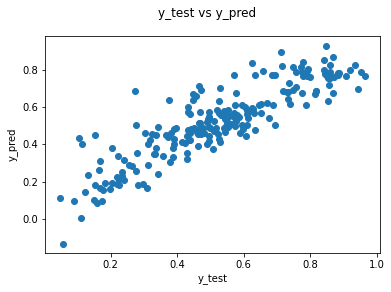

In [427]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred')              
plt.xlabel('y_test')                         
plt.ylabel('y_pred') 
plt.show()

#### Observations


*   Our final model using RFE has **R2-Score of 0.807** with train data and with test data predictions we got **0.772**. 
    F-statistic:                     232.8, 
    Prob (F-statistic):          1.59e-172
*   Our final model using manual elimination  has **R2-Score of 0.836** with train data and with test data predictions we got **0.796**.
F-statistic:                     254.0
Prob (F-statistic):          1.47e-188

#### It seems our manual model is good compared to RFE one.

## Final Observations


*   As per our manual feature elimination model, below are the top3 significant variables with their coefficients to predict the bike share rides count.
           

1.   temp             :   0.5499
2.   weathersit_3       :         -0.2880
3.   yr          :        0.2331


*   Our model has **R2-Score** of **0.836** with train data and with **test data** predictions we got **0.796** which is good.
*   Error terms are almost normally distrbuted with mean 0- this is one of the assumption for linear regression model
*  There is no multicollinearity in our model as VIFs are less than 5.
### Intepretations



1.   A unit increase in temp variable casues the bike share rides count increase by 0.5499 units
2. A unit increase in yr variable casues the bike share rides count increase by 0.2331 units
3. A unit increase in weathersit3(Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds variable casues the bike share rides count decrease by 0.2880 units



